# Diagnostics and statistics for TF model runs

This notebook explains the basic usage of the ModelDiagnostics class for computing statistics and plotting slices.

The model diagnostics class is part of the cbrain module in the CBRAIN-Keras-Diagnostics repository. To use, just `git clone git@github.com:raspstephan/CBRAIN-Keras-Diagnostics.git` and then create a link to the `cbrain` directory wherever you want to use the module.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from cbrain.imports import *
from cbrain.model_diagnostics import *

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Basics usage

Let's do some basic plotting and then compute global statistics. First we need to define a whole bunch of things. You probably need to change all the directories.

### Setup

In [3]:
# Define files and directories
model_dir = '/export/home/srasp/TF_models/'
model_path = f'{model_dir}saved_keras_model_0228a_964000.h5'
mean_path = f'{model_dir}mean_nolat_0213.nc'
std_path = f'{model_dir}std_nolat_0213.nc'

In [4]:
# Define input and output variables. Must be in the right order!
inps = ['TBP','QBP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']
outps = ['TPHYSTND_NORAD','PHQ']

In [5]:
# Define the aqua files we want to analyze. These must be preprocessed with the matlab script.
data_dir = '/scratch/srasp/Aquaplanet_enhance05_old_matlab/'
# Here we can define any pattern. 
# For a quick test lets pick the first 5 days from the first 3 months
aqua_pattern = f'{data_dir}AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-0[1-3]-0[1-5]-00000.nc'

Now create a model diagnostics object. For this we have to specify a few things in the beginning. Because it handles TF as well as Keras, all the TF specific parameters have a `tf_` prefix. The first argument `is_tf` decides whether internally it processes TF or Keras. Note that you also have to pass `nlev` if its not 30.

In [6]:
diag = ModelDiagnostics(
    is_tf=True, model_path=model_path, tf_filepattern=aqua_pattern, tf_fvars=inps, 
    tf_tvars=outps, tf_meanpath=mean_path, tf_stdpath=std_path, nlev=21)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
# Here is the model
diag.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 21, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              151552    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 42)                43050     
__________

In [8]:
# These are the files which are going to be used
diag.tf_files

['/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-01-00000.nc',
 '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-02-00000.nc',
 '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-03-00000.nc',
 '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-04-00000.nc',
 '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc',
 '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-02-01-00000.nc',
 '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-02-02-00000.nc',
 '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-02-03-00000.nc',
 '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-02-04-00000.nc',
 '/scratch

### Plotting
We can plot some slices for a single time step. Which time step is determined by the parameter `itime` starts at the first time step of the first file and continuously goes to the last time step of the last file. So if we wanted the 4th time step of the 2nd file, we would need to set `itime=48*2+4=100`.

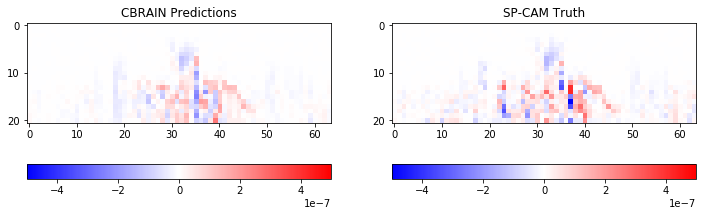

In [9]:
# Plot a lat-lev at longitude=0
# You can pass imshow arguments as well, such as cmap, and vmin, vmax
f = diag.plot_double_yz(itime=100, ilon=0, var='PHQ', cmap='bwr', vmin=-5e-7, vmax=5e-7)

Notice that I converted the level ordering back to the original where we start counting from the top!

Now let's plot a lat-lon slice at level 10.

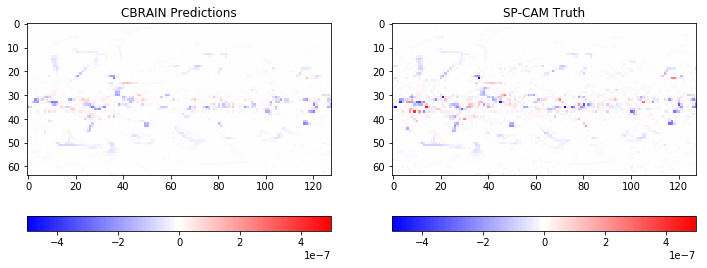

In [10]:
f = diag.plot_double_xy(itime=100, ilev=10, var='PHQ', cmap='bwr', vmin=-5e-7, vmax=5e-7)

In [11]:
# Save the figure 
f.savefig('/export/home/srasp/tmp/test_fig.png')

### Global statistics

We can also compute global statistics. For now the following are implemented on a grid box by grid box basis, so [lat, lon, var, lev].

- Bias
- MSE
- Variance of predictions
- Variance of truth
- R2

This can take a while since we are reading the aqua files from disc. On my setup I get a speed of around 3-4 time steps per second. So a full year would take around 1.5h.

In [12]:
diag.compute_stats()

100%|██████████| 720/720 [02:03<00:00,  5.82it/s]


Now we have a dictionary which contains the statistics. To make sure we don't have to recompute it every time, we can simply save it.

In [13]:
with open('/export/home/srasp/tmp/test_stats.pkl', 'wb') as f:
    pickle.dump(diag.stats, f)

In [14]:
# Now we can just load the stats dict next time
with open('/export/home/srasp/tmp/test_stats.pkl', 'rb') as f:
    diag.stats = pickle.load(f)

In [15]:
diag.stats.keys(), diag.stats['bias'].shape

(dict_keys(['bias', 'mse', 'pred_var', 'true_var', 'r2']), (64, 128, 2, 21))

We can now compute average statistics for each variable.

In [16]:
diag.mean_stats()

,bias,mse,pred_var,true_var,r2,r2_v2
TPHYSTND_NORAD,-6.65666e-07,2.16022e-09,1.24455e-09,2.78252e-09,0.129403,0.333073
PHQ,3.29247e-10,2.87328e-15,6.84432e-16,2.37336e-15,-1.08453,0.224692
all,NaN,NaN,NaN,NaN,NaN,0.278883


Note that at the moment I am a little uncertain about the R2 score, so I might change that. Currently, I think `r2_v2` is closest to what you have.

The R2 score seems to depend on the sample size, so trying it for a much larger dataset is probably a good idea.

We can also plot the global statistics.

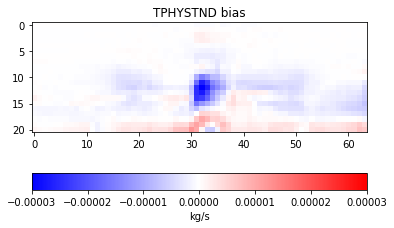

In [17]:
# Plot the bias in TPHYSTND averaged over all longitudes
f = diag.plot_slice(np.mean(diag.stats['bias'][:, :, 0, :].T, axis=1), cmap='bwr', 
                    vmin=-3e-5, vmax=3e-5, title='TPHYSTND bias', unit='kg/s')

## Actual statistics for the latest networks.

I will compute statistics for days 5-9 from each month of my 2nd year of data. This amounts to 60 days in total. 

In [18]:
data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05/'
valid_pattern = f'{data_dir}AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-*-2[1-5]-00000.nc'

In [23]:
def run_stats(model_name, watch_mem=True, compute_stats=True):
    model_path = f'{model_dir}{model_name}.h5'
    diag = ModelDiagnostics(
        is_tf=True, model_path=model_path, tf_filepattern=valid_pattern, tf_fvars=inps, 
        tf_tvars=outps, tf_meanpath=mean_path, tf_stdpath=std_path, nlev=21, watch_mem=watch_mem)
    print(diag.model.summary())
    if compute_stats:
        stats_path = f'{model_dir}{model_name}_stats.pkl'
        if os.path.exists(stats_path):
            with open(f'{model_dir}{model_name}_stats.pkl', 'rb') as f:
                diag.stats = pickle.load(f)
        else:
            diag.compute_stats()
            with open(f'{model_dir}{model_name}_stats.pkl', 'wb') as f:
                pickle.dump(diag.stats, f)
        print(diag.mean_stats())
    return diag

In [20]:
tf_models = ['saved_keras_model_0228a_964000', 'saved_keras_model_0228b_1349000', 
             'saved_keras_model_0228c_999000', 'saved_keras_model_0303a',
             'saved_keras_model_0303b_2', 'saved_keras_model_0303c_3']

### Test the TF models

In [24]:
run_stats(tf_models[0])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 21, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              151552    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 42)                43050     
__________

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
run_stats(tf_models[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 21, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              151552    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 42)                43050     
__________

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [26]:
run_stats(tf_models[2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 21, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              303104    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 42)                86058     
__________

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


 11%|█▏        | 328/2880 [00:50<06:29,  6.55it/s]

In [27]:
run_stats(tf_models[3])

OSError: Unable to open file (truncated file: eof = 74711040, sblock->base_addr = 0, stored_eof = 83208216)

In [28]:
run_stats(tf_models[4])

ValueError: bad marshal data (unknown type code)

In [29]:
run_stats(tf_models[5])

ValueError: bad marshal data (unknown type code)

### A Keras model as comparison

In [17]:
keras_dir = '/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/'
k_data_dir =  '/scratch/srasp/preprocessed_data/'

In [47]:
def run_keras_stats(model_name, compute_stats=True):
    model_path = f'{keras_dir}{model_name}.h5'
    diag = ModelDiagnostics(False, model_path, 
                        k_fpath=f'{k_data_dir}tfcomp_valid_sample1_features.nc',
                        k_tpath=f'{k_data_dir}tfcomp_valid_sample1_targets.nc',
                        k_npath=f'{k_data_dir}tfcomp_train_sample1_norm.nc',
                        k_norms=('feature_means', 'max_rs', None, 'target_conv'))
    diag.model.summary()
    if compute_stats:
        diag.compute_stats()
        print(diag.mean_stats(9))
    return diag

In [23]:
run_keras_stats('C001_tfcomp_sample1_base')

/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:259: RuntimeWarning: divide by zero encountered in true_divide
  lev_r2 = 1. - (np.mean(mse, axis=(0, 1)) / np.mean(true_var, axis=(0, 1)))


,bias,mse,pred_var,true_var,r2,r2_v2
TPHYSTND_NORAD,-3.84903e-08,9.18615e-10,1.0221e-09,1.96006e-09,-1.87959,0.520442
PHQ,3.39118e-11,1.15438e-15,4.43491e-16,1.61621e-15,-inf,0.493843
all,NaN,NaN,NaN,NaN,NaN,0.507143


In [35]:
d = run_keras_stats('C002_tfcomp_sample1_deep1')

  0%|          | 2/2868 [00:00<02:54, 16.44it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               63488     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
__________

100%|██████████| 2868/2868 [02:01<00:00, 23.58it/s]


                       bias          mse     pred_var     true_var        r2  \
TPHYSTND_NORAD  -2.4994e-08  1.10278e-09  1.66016e-09  2.74899e-09  0.295163   
PHQ            -1.87676e-11  1.52708e-15  7.98396e-16  2.30887e-15  -13.2006   
all                     NaN          NaN          NaN          NaN       NaN   

                   r2_v2  
TPHYSTND_NORAD  0.586434  
PHQ             0.517906  
all             0.552170  


/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:235: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:259: RuntimeWarning: divide by zero encountered in true_divide
  lev_r2 = 1. - (np.mean(mse, axis=(0, 1)) / np.mean(true_var, axis=(0, 1)))


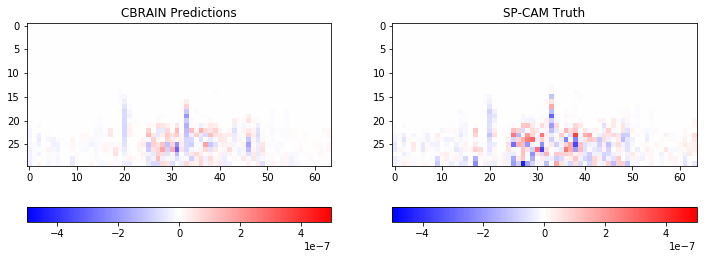

In [36]:
f = d.plot_double_yz(itime=100, ilon=0, var='PHQ', cmap='bwr', vmin=-5e-7, vmax=5e-7)

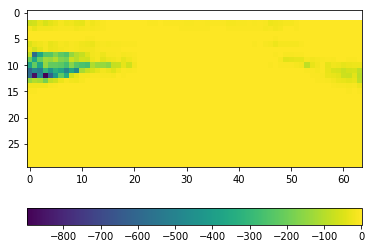

In [40]:
f = d.plot_slice(d.stats['r2'][:, 0, 1, :].T)

## Are we doing something wrong for the TF statistics?

In [45]:
dtf = run_stats(tf_models[2], compute_stats=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 21, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              303104    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 42)                86058     
__________

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


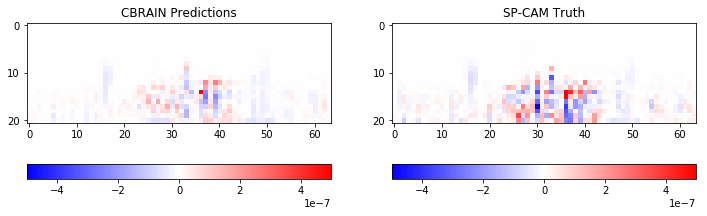

In [53]:
f = dtf.plot_double_yz(itime=1, ilon=0, var='PHQ', cmap='bwr', vmin=-5e-7, vmax=5e-7)

In [48]:
dk = run_keras_stats('C002_tfcomp_sample1_deep1', compute_stats=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               63488     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
__________

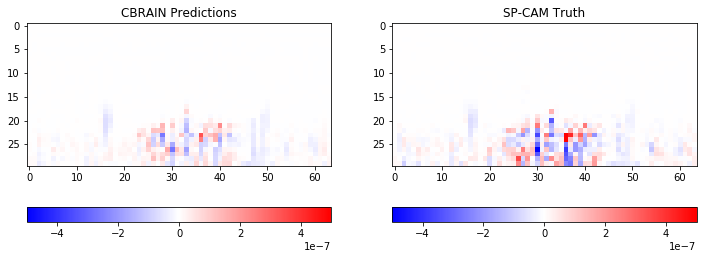

In [52]:
f = dk.plot_double_yz(itime=0, ilon=0, var='PHQ', cmap='bwr', vmin=-5e-7, vmax=5e-7)

In [65]:
ptf, ttf = dtf.get_pt(1, 'PHQ')

In [66]:
pk, tk = dk.get_pt(0, 'PHQ')

In [61]:
ttf.shape, tk.shape

((64, 128, 21), (64, 128, 30))

In [64]:
np.allclose(ttf, tk[:, :, 9:])

True

So this means that we are getting comparing to the same values. Can we confirm that the error of the TF model is higher?

In [68]:
msetf = np.mean((ptf - ttf)**2)
msek = np.mean((pk[:, :, 9:] - tk[:, :, 9:])**2)
msetf, msek

(2.7161429e-15, 1.5000208e-15)

Yes! This about confirms our picture from above. Could it be that the variance is higher?

In [69]:
np.var(ptf), np.var(pk[:, :, 9:])

(6.8958e-16, 8.01556e-16)

No, the variance of the Keras model is higher.